<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Chapter 4

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from urllib.request import urlretrieve
from io import StringIO

In [142]:
file = 'markets_cleaned.csv'
url = 'https://assets.datacamp.com/production/repositories/3841/datasets/efdbc5d7c7b734f0b091d924605c4ad2664ef830/'
urlretrieve(url+file, file)
markets_clean = pd.read_csv(file)
markets_clean.rename({'lon': 'lat', 'lat':'lon'},
                     axis=1,
                     inplace=True)

In [143]:
markets_clean.columns

Index(['FMID', 'name', 'city', 'county', 'state', 'lon', 'lat', 'months_open',
       'Bakedgoods', 'Beans', 'Cheese', 'Coffee', 'Crafts', 'Eggs', 'Flowers',
       'Fruits', 'Grains', 'Herbs', 'Honey', 'Jams', 'Juices', 'Maple', 'Meat',
       'Mushrooms', 'Nursery', 'Nuts', 'PetFood', 'Plants', 'Poultry',
       'Prepared', 'Seafood', 'Soap', 'Tofu', 'Trees', 'Vegetables',
       'WildHarvested', 'Wine'],
      dtype='object')

In [144]:
markets_clean['num_items_sold'] = markets_clean.select_dtypes('int').drop(['FMID'], axis=1).sum(axis=1)

In [145]:
file = 'census-state-populations.csv'
url = 'https://assets.datacamp.com/production/repositories/3841/datasets/f0dbd061f3851ac130cf2f8ad6b3f28f1d19c1fd/'
urlretrieve(url+file, file)
pops = pd.read_csv(file)
pops.columns = ['state', 'state_pop']
pops.head()

,state,state_pop
0,Alabama,4849377
1,Alaska,736732
2,Arizona,6731484
3,Arkansas,2966369
4,California,38802500


In [146]:
markets = pd.merge(markets_clean, pops,
                  how='left',
                  on='state')
markets.head(1)

,FMID,name,city,county,state,lon,lat,months_open,Bakedgoods,Beans,...,Prepared,Seafood,Soap,Tofu,Trees,Vegetables,WildHarvested,Wine,num_items_sold,state_pop
0,1018261,Caledonia Farmers Market Association - Danville,Danville,Caledonia,Vermont,-72.140337,44.411036,3.0,1,1,...,1,0,1,0,1,1,0,0,20,626562.0


In [147]:
# Print first three rows of data and transpose
first_rows = markets.head(3).transpose()
print(first_rows)

# Get descriptions of every column
col_descriptions = markets.describe(include = 'all',
                                percentiles = [0.5]).transpose()
print(col_descriptions)

                                                              0  \
FMID                                                    1018261   
name            Caledonia Farmers Market Association - Danville   
city                                                   Danville   
county                                                Caledonia   
state                                                   Vermont   
lon                                                    -72.1403   
lat                                                      44.411   
months_open                                                   3   
Bakedgoods                                                    1   
Beans                                                         1   
Cheese                                                        1   
Coffee                                                        1   
Crafts                                                        1   
Eggs                                                          

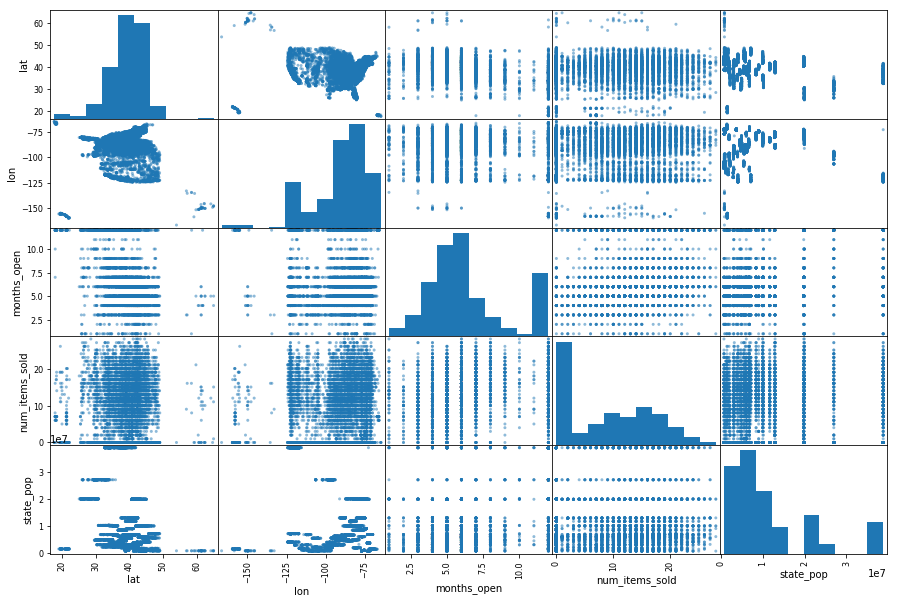

In [148]:
# Select just the numeric columns (exluding individual goods)
numeric_columns = ['lat', 'lon', 'months_open', 'num_items_sold', 'state_pop']

# Make a scatter matrix of numeric columns
pd.plotting.scatter_matrix(markets[numeric_columns], 
                             # Make figure large to show details
                             figsize = (15,10), 
                           # Lower point opacity to show overlap
                           alpha = 0.5)
plt.show()

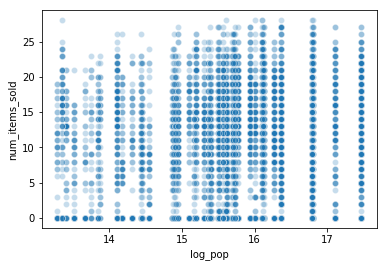

In [149]:
# Create a new logged population column 
markets['log_pop'] = np.log(markets['state_pop'])

# Draw a scatterplot of log-population to # of items sold
sns.scatterplot(x = 'log_pop', 
                  y = 'num_items_sold', 
                  # Reduce point opacity to show overlap
                  alpha = 0.25, 
                  data = markets)
plt.show()

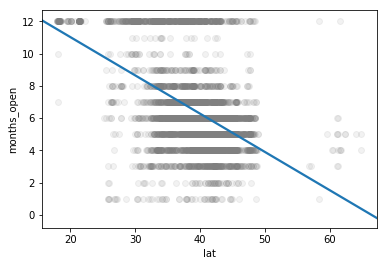

In [150]:
sns.regplot(x = 'lat', 
            y = 'months_open', 
            # Set scatter point opacity & color
            scatter_kws = {'alpha':0.1, 'color':'gray'}, 
            # Disable confidence band
            ci = False, 
            data = markets)
plt.show()

In [151]:
markets_and_pop = (markets
    .groupby('state', as_index = False)
    .agg({
       'name': ['count', lambda d: np.log(len(d))],
       'state_pop': ['max', lambda d: np.log(d.iloc[0])]
    }))
markets_and_pop.columns = ['state', 'num_markets', 'log_markets', 'state_pop', 'log_pop']

In [152]:
markets_and_pop.dropna(inplace=True)

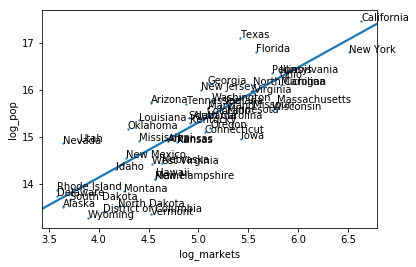

In [153]:
g = sns.regplot(
    "log_markets", "log_pop", 
    ci = False,
    # Shrink scatter plot points
    scatter_kws = {'s':2},
    data = markets_and_pop)

# Iterate over the rows of the data
for _, row in markets_and_pop.iterrows():
    state, _, log_markets, _, log_pop = row
    # Place annotation and reduce size for clarity
    g.annotate(state, (log_markets, log_pop), size = 10)

plt.show()

In [154]:
drop_cols = ['FMID', 'lat', 'lon', 'months_open', 'num_items_sold', 'state_pop', 'log_pop']
goods_by_state = (markets.drop(drop_cols, axis=1)
                         .groupby('state')
                         .mean()
                         .stack()
                         .reset_index())
goods_by_state.columns = ['state', 'good', 'prop_selling']

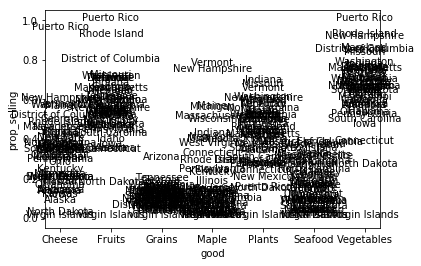

In [155]:
# Subset goods to interesting ones
to_plot = ['Cheese','Maple','Fruits','Grains','Seafood','Plants','Vegetables']
goods_by_state_small = goods_by_state.query("good in "+str(to_plot))

g = sns.scatterplot('good','prop_selling', data = goods_by_state_small,
                    # Hide scatter points by shrinking to nothing
                    s = 0)

for _,row in goods_by_state_small.iterrows():
  g.annotate(row['state'], (row['good'], row['prop_selling']), 
             # Center annotation on axis
             ha = 'center', 
             size = 10)

plt.show()

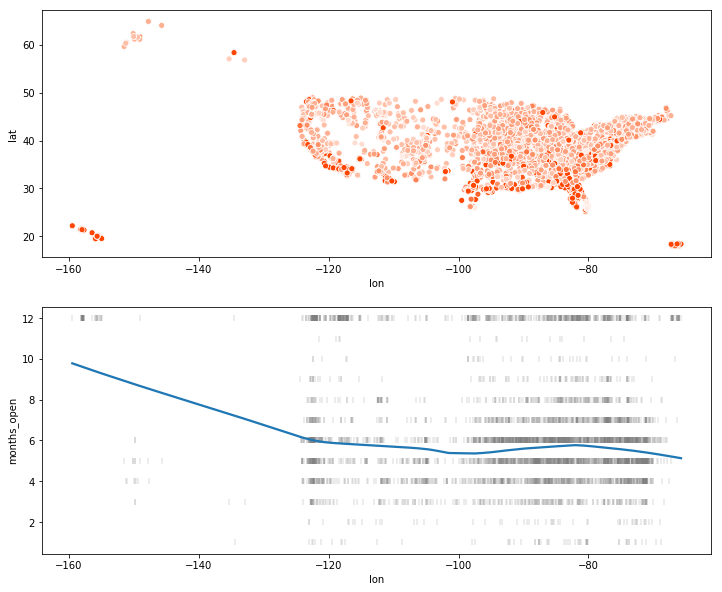

In [156]:
# Setup two stacked plots
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10))

# Draw location scatter plot on first plot
sns.scatterplot("lon", "lat", 'months_open', 
                palette = sns.light_palette("orangered",n_colors = 12), 
                legend = False, data = markets,
                ax = ax1);

# Plot a regression plot on second plot
sns.regplot('lon', 'months_open',
            scatter_kws = {'alpha': 0.2, 'color': 'gray', 'marker': '|'},
            lowess = True,
            marker = '|', data = markets, 
            ax = ax2)

plt.show()

In [162]:
markets_and_pop.columns

Index(['state', 'num_markets', 'log_markets', 'state_pop', 'log_pop'], dtype='object')

In [180]:
plt.style.use('seaborn')
markets_by_state = markets_and_pop.copy()
markets_by_state.rename({'state_pop': 'population'},
                        axis=1,
                        inplace=True)
markets_by_state['people_per_market'] = markets_by_state['population']/markets_by_state['num_markets']
markets_by_state['is_selected'] = 'other'
for state in ['Vermont', 'Maryland', 'Texas']:
    idx = markets_by_state['state'] == state
    markets_by_state.loc[idx, 'is_selected'] = state
markets_by_state.sort_values(by='people_per_market', inplace=True)

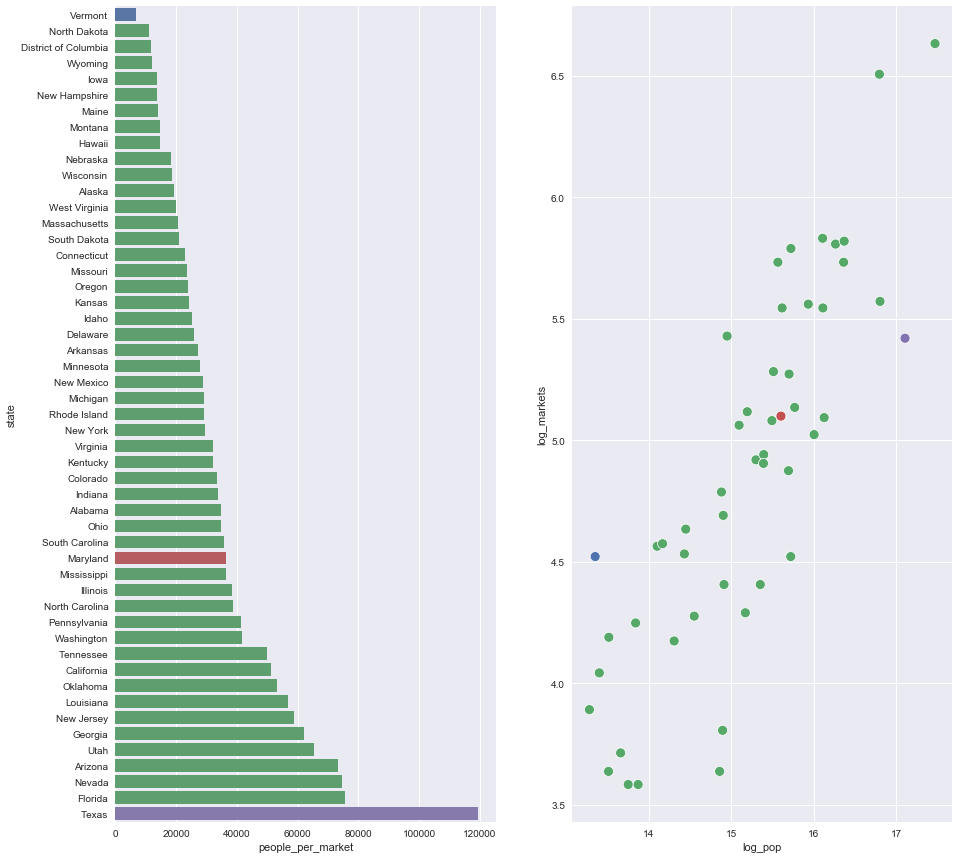

In [181]:
# Set up two side-by-side plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

# Map the column for selected states to the bar color
sns.barplot('people_per_market', 'state', hue = 'is_selected',
            # Disable dodge so bars are full size
            dodge = False, 
            data = markets_by_state, ax = ax1)

# Map selected states to point color
sns.scatterplot('log_pop', 'log_markets', hue = 'is_selected', 
                data = markets_by_state, ax = ax2, s = 100)

# Remove the legend for both plots
ax1.legend_.remove()
ax2.legend_.remove() 
plt.show() 

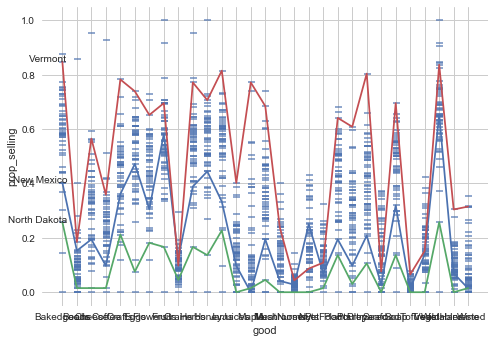

In [184]:
# Set background to white with grid
sns.set_style('whitegrid')

plt.scatter('good','prop_selling', marker = '_', alpha = 0.7, data = goods_by_state)

# Draw lines across goods for highlighted states
highlighted = goods_by_state.query("state in ['New Mexico','North Dakota','Vermont']")
sns.lineplot('good','prop_selling', 'state', data = highlighted, legend = False)

# Draw state name at end of lines
last_rows = highlighted.groupby('state', as_index = False).agg('first')
for _,row in last_rows.iterrows():
    plt.annotate(row['state'], (row['good'], row['prop_selling']),
                 ha = 'right', xytext = (5,0), textcoords = 'offset pixels')

# Remove all borders
sns.despine(bottom = True, left = True)
plt.show()

In [220]:
markets_by_month_abs = (markets[['state', 'months_open', 'lon']].groupby(['state', 'months_open'])
                                                                .count()
                                                                .reset_index()
                                                                .pivot('state', 'months_open', 'lon')
                                                                .fillna(0))
markets_by_month_abs['total'] = markets_by_month_abs.sum(axis=1)
markets_by_month_abs
for col in markets_by_month_abs.columns.str.

months_open,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,total
state,,,,,,,,,,,,,
Alabama,1.0,4.0,14.0,14.0,8.0,9.0,7.0,4.0,0.0,1.0,0.0,9.0,71.0
Alaska,1.0,0.0,4.0,7.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,24.0
Arizona,1.0,0.0,2.0,7.0,4.0,8.0,7.0,20.0,1.0,0.0,0.0,16.0,66.0
Arkansas,1.0,0.0,0.0,5.0,10.0,12.0,13.0,4.0,2.0,1.0,1.0,10.0,59.0
California,6.0,0.0,13.0,26.0,52.0,57.0,26.0,15.0,11.0,3.0,4.0,229.0,442.0
Colorado,0.0,0.0,8.0,32.0,29.0,19.0,4.0,2.0,0.0,0.0,0.0,4.0,98.0
Connecticut,0.0,3.0,0.0,10.0,23.0,5.0,6.0,2.0,2.0,0.0,0.0,3.0,54.0
Delaware,1.0,1.0,4.0,3.0,7.0,7.0,2.0,1.0,1.0,0.0,0.0,1.0,28.0
District of Columbia,0.0,0.0,1.0,2.0,7.0,10.0,15.0,3.0,4.0,0.0,0.0,2.0,44.0


In [232]:
month_cols = pd.to_numeric(markets_by_month_abs.columns, errors='coerce').dropna()
for col in month_cols:
    markets_by_month_abs[col] = markets_by_month_abs[col] / markets_by_month_abs['total']
markets_by_month = markets_by_month_abs.drop('total', axis=1)

state_by_lat = ['North Dakota', 'Washington', 'Montana', 'Minnesota', 'Oregon', 'Idaho', 'Maine', 'South Dakota', 'Vermont', 'Wisconsin', 'Michigan', 'New Hampshire', 'Wyoming', 'Massachusetts', 'New York',
       'Iowa', 'Rhode Island', 'Connecticut', 'Nebraska', 'Illinois', 'Ohio', 'New Jersey', 'Pennsylvania', 'Indiana', 'Utah', 'Colorado', 'Delaware', 'Maryland', 'West Virginia',
       'District of Columbia', 'Kansas', 'Nevada', 'Missouri', 'Virginia', 'Kentucky', 'California', 'Tennessee', 'Oklahoma', 'North Carolina', 'Arkansas', 'New Mexico', 'South Carolina', 'Georgia',
       'Arizona', 'Alabama', 'Mississippi', 'Texas', 'Louisiana', 'Florida']

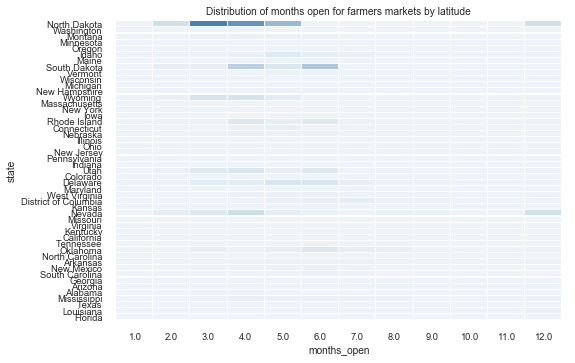

In [234]:
# Decrease font size so state names are less crowded
sns.set(font_scale = 0.85)

# Switch to an appropriate color palette
blue_pal = sns.light_palette("steelblue", as_cmap = True)

# Order states by latitude
g = sns.heatmap(markets_by_month.reindex(state_by_lat), 
            # Add gaps between cells
            linewidths = 0.1, 
            # Set new palette and remove color bar 
            cmap = blue_pal, cbar = False,
            yticklabels = True)

# Rotate y-axis ticks 
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
plt.title('Distribution of months open for farmers markets by latitude')
plt.show()

In [272]:
state_colors = ['steelblue',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'orangered']

tx_message = 'Texas has a large population\nand relatively few farmers\nmarkets.'

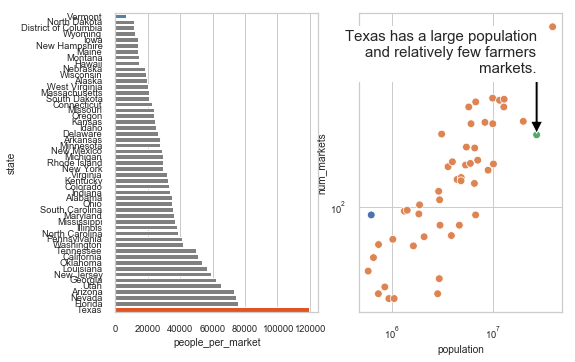

In [274]:
_, (ax1, ax2) = plt.subplots(1,2)

# Draw barplot w/ colors mapped to state_colors vector
sns.barplot('people_per_market', 'state', palette = state_colors,
            data = markets_by_state, ax = ax1)

# Map state colors vector to the scatterplot as well
p = sns.scatterplot('population', 'num_markets', 
                    hue = state_colors,
                    data = markets_by_state, s = 60, ax = ax2)
ax2.legend_.remove()

# Log the x and y scales of our scatter plot so it's easier to read
ax2.set(xscale = "log", yscale = 'log')

# Increase annotation text size for legibility
ax2.annotate(tx_message, xy = (26956958,230), 
             xytext = (26956958, 450),ha = 'right', 
             size = 15, backgroundcolor = 'white',
             arrowprops = {'facecolor':'black', 'width': 3})
sns.set_style('whitegrid')
plt.show()